In [49]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
data100_df = pd.read_excel(io='dados exp4.ods', sheet_name='abertura_100', engine='odf')
data60_df = pd.read_excel(io='dados exp4.ods', sheet_name='abertura_60', engine='odf')

In [51]:
data60_df.columns

Index(['ponto', 'medição', 'coluna mm', 'abertura', 'posição (cm)'], dtype='str')

In [52]:
# 2. Constantes Físicas para a Equação de Bernoulli
g = 9.81           # m/s^2 (Aceleração da gravidade)
rho_agua = 1000    # kg/m^3 (Densidade da água manométrica)
rho_ar = 1.225     # kg/m^3 (Densidade do ar ambiente)

# 3. Unindo os dados para encontrar a Função de Transferência do Sensor (Regressão Linear global)
# Extraímos os arrays do Pandas para o SciPy calcular a correlação entre as medições do ADC e a coluna de água
todas_medicoes_arduino = np.concatenate([data100_df['medição'].values, data60_df['medição'].values])
todas_colunas_agua_mm = np.concatenate([data100_df['coluna mm'].values, data60_df['coluna mm'].values])

# Calculando a regressão linear: h(mm) = slope * ADC + intercept
slope, intercept, r_value, p_value, std_err = linregress(todas_medicoes_arduino, todas_colunas_agua_mm)

# 4. Função de conversão automatizada: ADC -> mmH2O -> Metros -> m/s
def adc_para_velocidade(leitura_adc):
    h_mm = (slope * leitura_adc) + intercept    # Calibração via Reta (Função de transferência)
    h_m = h_mm / 1000.0                         # Conversão de milímetros para metros

    # Tratamento para evitar raízes de números negativos devido à variância do sensor em medições muito baixas
    if h_m < 0:
        h_m = 0

    velocidade = np.sqrt((2 * rho_agua * g * h_m) / rho_ar) # Aplicação de Bernoulli
    return velocidade

# 5. Aplicação da função nas colunas do DataFrame para criar a coluna de velocidade calculada
# O método .apply() do Pandas passa cada valor da coluna 'medição' pela função que criamos
data100_df['velocidade (m/s)'] = data100_df['medição'].apply(adc_para_velocidade)
data60_df['velocidade (m/s)'] = data60_df['medição'].apply(adc_para_velocidade)

In [53]:
# Exibindo os resultados finais para conferência
print(f"Equação de Calibração: Coluna(mm) = {slope:.4f} * ADC + {intercept:.4f} (R² = {r_value**2:.4f})")
print("\nVelocidades Calculadas - Abertura 100%:")
data100_df.to_latex('tabela_experimento_pitot.tex', index=False, float_format='%.2f', caption='Velocidades Calculadas - Abertura 100\\%', label='tab:pitot_100', column_format='|c|c|c|c|c|c|', position='!htbp', multicolumn_format='c')

data60_df.to_latex('tabela_experimento_pitot2.tex', index=False, float_format='%.2f', caption='Velocidades Calculadas - Abertura 60\\%', label='tab:pitot_60', column_format='|c|c|c|c|c|c|', position='!htbp', multicolumn_format='c')


Equação de Calibração: Coluna(mm) = 1.5454 * ADC + -808.9184 (R² = 0.8513)

Velocidades Calculadas - Abertura 100%:


In [54]:
print("\nVelocidades Calculadas - Abertura 60%:")
data60_df[['posição (cm)', 'coluna mm', 'medição', 'velocidade (m/s)']]




Velocidades Calculadas - Abertura 60%:


,posição (cm),coluna mm,medição,velocidade (m/s)
0,0,20,540.217391,20.375362
1,1,24,543.632850,22.353797
2,2,28,548.202899,24.754932
3,3,30,549.202899,25.249909
4,4,30,547.125604,24.210375
5,5,28,540.149758,20.334241
6,6,26,532.376812,14.869136


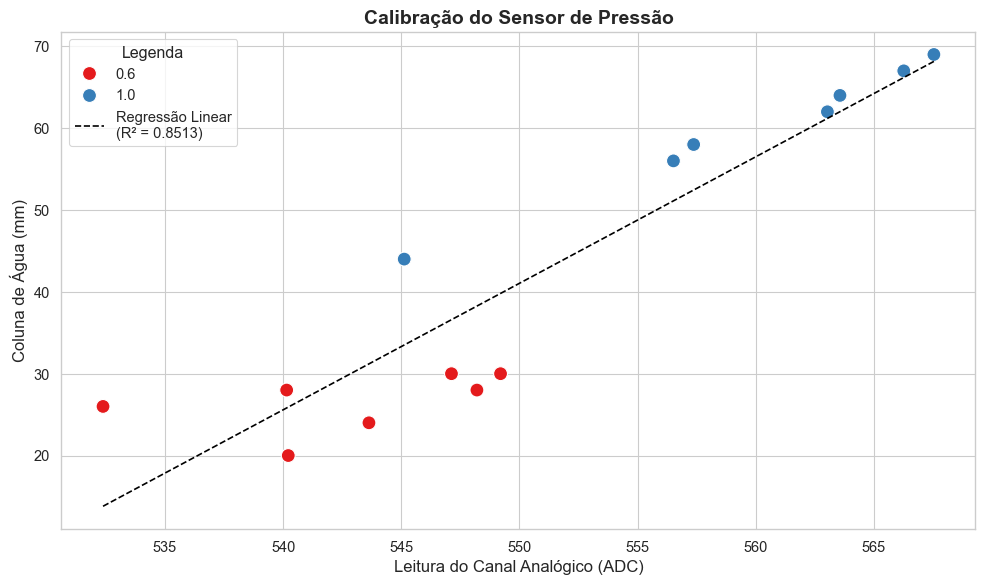

In [55]:
# 1. Unindo os DataFrames para facilitar a plotagem com Seaborn
df_completo = pd.concat([data100_df, data60_df], ignore_index=True)

# 2. Configurando o estilo visual acadêmico (ideal para relatórios)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# 3. Tamanho base para as figuras (Ajuste para 10x6 para proporções ideais em relatórios/Word)
figure_size = (10, 6)
rangeval = 1

# ==============================================================================
# GRÁFICO 1: Curva de Calibração (ADC vs Coluna de Água)
# ==============================================================================
fig1, axes1 = plt.subplots(figsize=(figure_size[0] * rangeval, figure_size[1] * rangeval))

# Plota os pontos reais medidos
sns.scatterplot(
    data=df_completo,
    x='medição',
    y='coluna mm',
    hue='abertura',
    palette='Set1',
    s=100,
    ax=axes1
)

# Adiciona a linha de tendência (Regressão Linear calculada no passo anterior)
# Nota: as variáveis 'slope', 'intercept' e 'r_value' devem estar na memória
x_val = np.linspace(df_completo['medição'].min(), df_completo['medição'].max(), 100)
y_val = slope * x_val + intercept
axes1.plot(x_val, y_val, color='black', linestyle='--', label=f'Regressão Linear\n(R² = {r_value ** 2:.4f})')

axes1.set_title('Calibração do Sensor de Pressão', fontsize=14, weight='bold')
axes1.set_xlabel('Leitura do Canal Analógico (ADC)', fontsize=12)
axes1.set_ylabel('Coluna de Água (mm)', fontsize=12)

# Correção da legenda para mesclar o scatterplot e a linha do plt.plot
handles, labels = axes1.get_legend_handles_labels()
axes1.legend(handles=handles, labels=labels, title='Legenda')

plt.tight_layout()
plt.savefig('grafico1_experimento_pitot.png', dpi=300)  # Salva em alta resolução
plt.show()

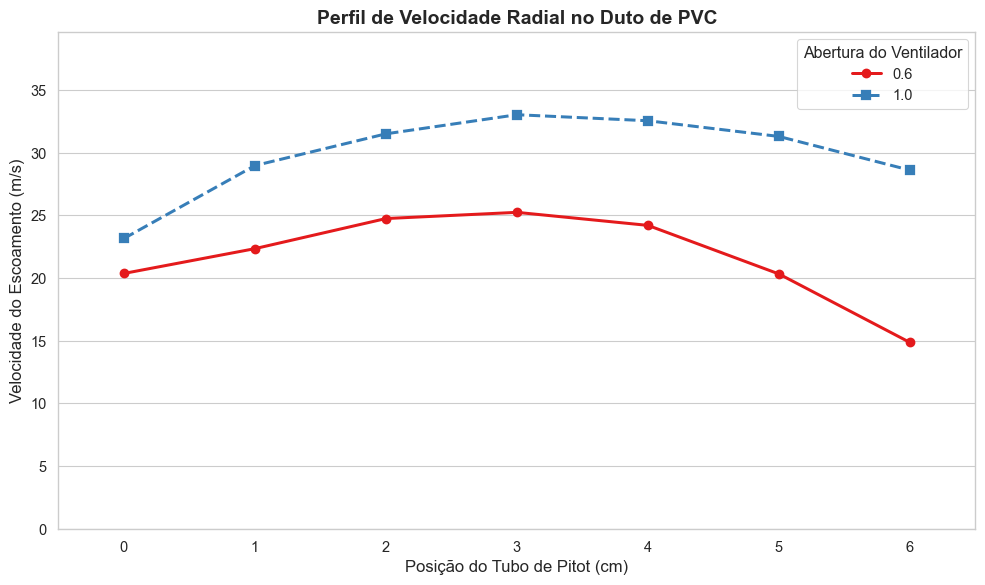

In [56]:

# ==============================================================================
# GRÁFICO 2: Perfil de Velocidades no Túnel de Vento
# ==============================================================================
fig2, axes2 = plt.subplots(figsize=(figure_size[0] * rangeval, figure_size[1] * rangeval))

# pointplot traça a linha contínua e marca os pontos exatos do Pitot
sns.pointplot(
    data=df_completo,
    x='posição (cm)',
    y='velocidade (m/s)',
    hue='abertura',
    palette='Set1',
    markers=['o', 's'],  # Círculos para 100%, Quadrados para 60%
    linestyles=['-', '--'],
    ax=axes2  # <--- CORREÇÃO AQUI (antes estava axes1)
)

axes2.set_title('Perfil de Velocidade Radial no Duto de PVC', fontsize=14, weight='bold')
axes2.set_xlabel('Posição do Tubo de Pitot (cm)', fontsize=12)
axes2.set_ylabel('Velocidade do Escoamento (m/s)', fontsize=12)

# Forçar o eixo Y a começar do zero para não distorcer a percepção da velocidade
axes2.set_ylim(0, df_completo['velocidade (m/s)'].max() * 1.2)
axes2.legend(title='Abertura do Ventilador')

# 4. Ajustando o espaçamento e renderizando
plt.tight_layout()
plt.savefig('grafico2_experimento_pitot.png', dpi=300)  # Salva em alta resolução
plt.show()
